# Setup

## Imports

In [1]:
import vaidata
import vaikeras

from vaiutils import path_consts, smooth_plot
from vaikaggle import dataset_consts, plot_prediction_density
from vaikeras import get_batches

Using TensorFlow backend.


In [2]:
from tqdm import tqdm_notebook

All the Keras modules

In [36]:
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Conv2D, GlobalAvgPool2D, Activation, Dropout, Input, Lambda
from keras.regularizers import l2

## Define useful variables and functions

In [4]:
for k, v in path_consts('StateFarm'):
    exec(k + '=v')
for k, v in dataset_consts(DIR_DATA, use_sample=False):
    exec(k + '=v')

In [5]:
def pickle_load(filename, default=None, path=DIR_CHECKPOINTS):
    return vaidata.pickle_load(path + '/' + filename + '.p', default)

In [6]:
def pickle_dump(filename, obj, path=DIR_CHECKPOINTS):
    vaidata.pickle_dump(path + '/' + filename + '.p', obj)

In [7]:
def inflate_model(name):
    return vaikeras.inflate_model(DIR_CHECKPOINTS + '/' + name + '.h5', name,
                                  DIR_CHECKPOINTS + '/' + name + '-history.p')

In [8]:
def plot_history():
    smooth_plot(model.training_history, remove_outlier=False, keys=['acc', 'val_acc'])
    plt.show()
    smooth_plot(model.training_history, remove_outlier=False, keys=['loss', 'val_loss'])
    plt.show()

In [9]:
def fit_model(epochs=1, lr=None, save=False):
    save_path = DIR_CHECKPOINTS if save else ''
    vaikeras.fit_model(model, train_batches, epochs,
                       lr, valid_batches, save_path)
    plot_history()

## Get data

In [20]:
generator = ImageDataGenerator()
generator_augmented = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                                         height_shift_range=0.05, shear_range=0.1,
                                         channel_shift_range=20)

In [21]:
train_batches = get_batches(DIR_TRAIN, generator_augmented, 64)
valid_batches = get_batches(DIR_VALID, generator, 64, False)

Found 19061 images belonging to 10 classes.
Found 3363 images belonging to 10 classes.


# ConvNet

In [15]:
def get_model():
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Conv2D(32, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Conv2D(64, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Flatten(),
                        Dense(100, activation='relu'),
                        BatchNormalization(),
                        Dense(10, activation='softmax')])

    model.name = 'ConvNet-Full'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20070500  
__________

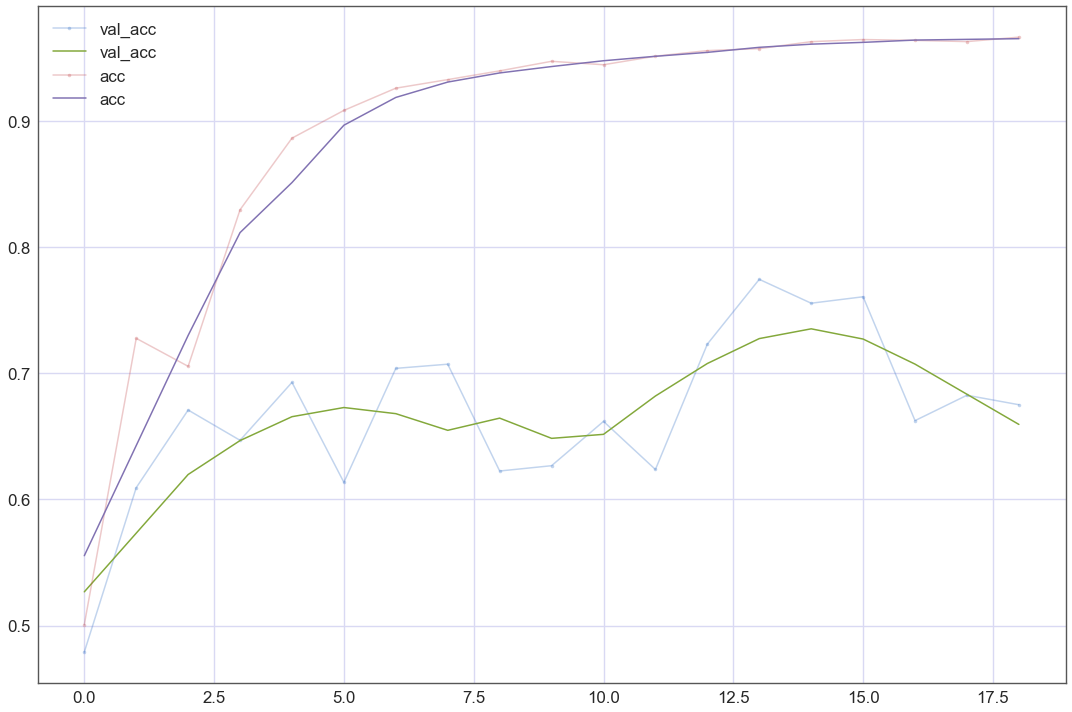

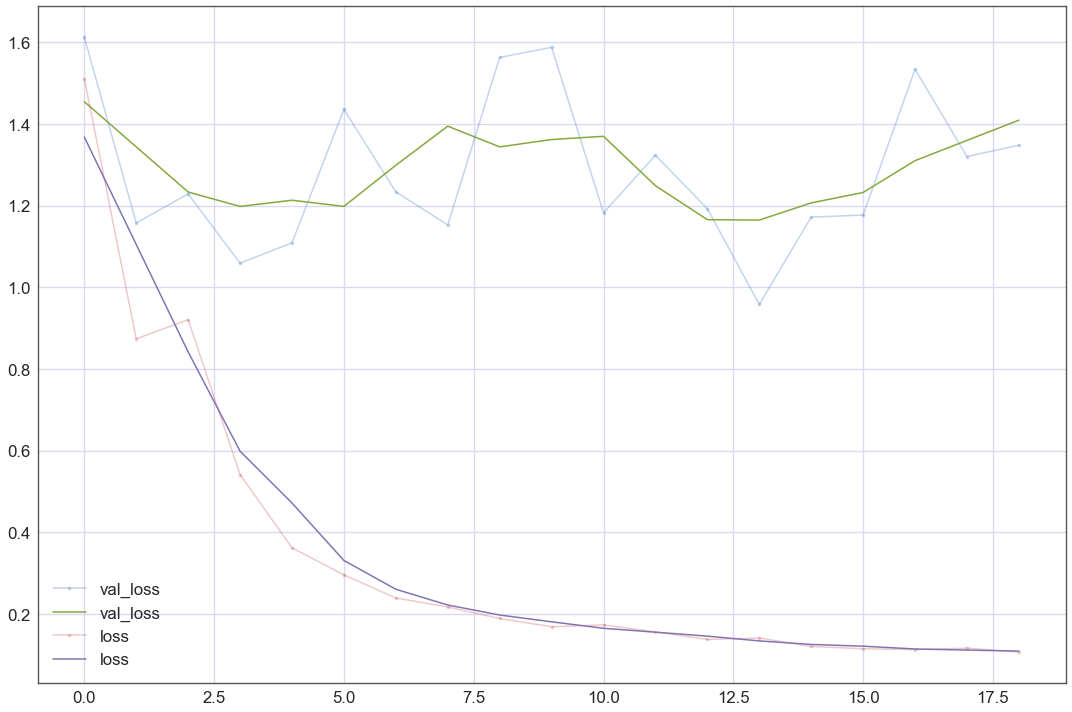

In [22]:
fit_model([2, 4, 13], [1e-4, 1e-3, 1e-4], save=True)

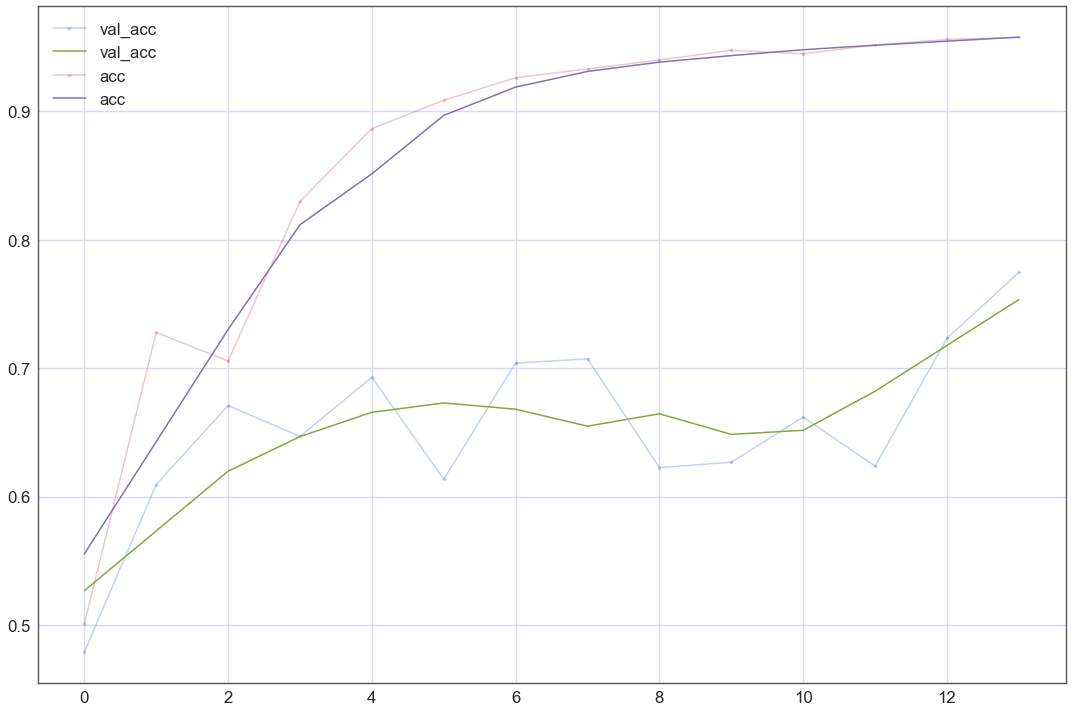

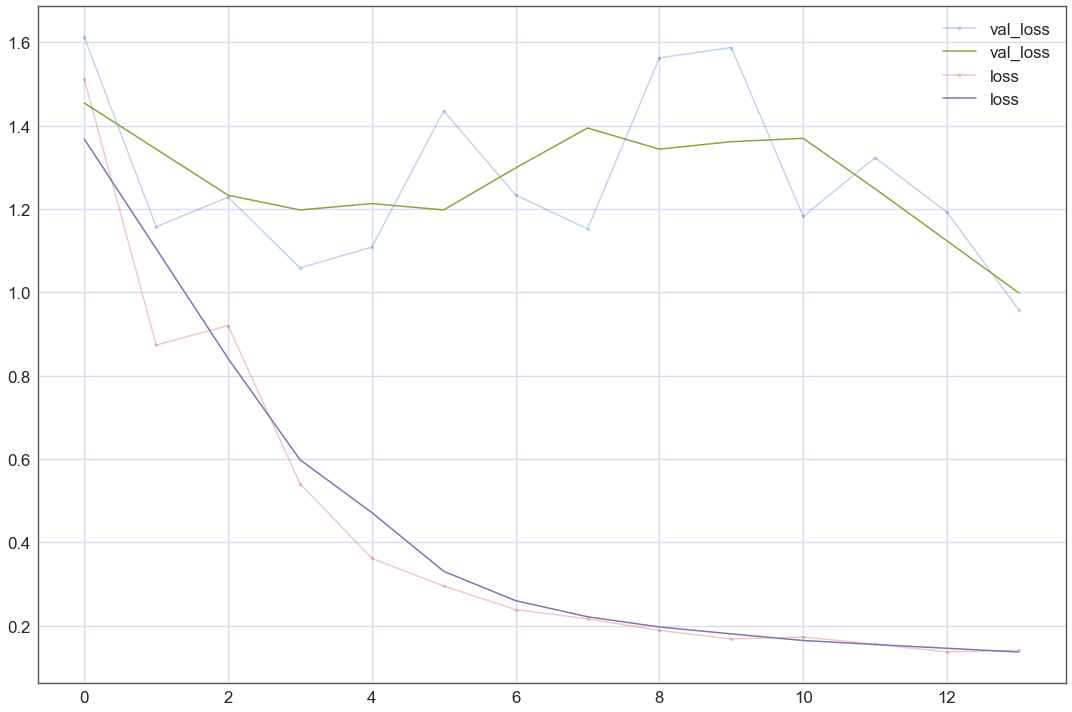

In [24]:
model=inflate_model('ConvNet-Full')
plot_history()

# Fully Convolutional Net

In [21]:
def get_model(dropout=0):
    K.clear_session()
    model = Sequential([BatchNormalization(input_shape=(224, 224, 1)),
                        Conv2D(32, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Dropout(dropout),
                        Conv2D(64, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Conv2D(128, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Conv2D(256, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Conv2D(10, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        GlobalAvgPool2D(),
                        Activation('softmax')])

    model.name = 'FullyConvNet'
    model.training_history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
norm (Lambda)                (None, 224, 224, 1)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10)                412854    
Total params: 412,854
Trainable params: 411,872
Non-trainable params: 982
_________________________________________________________________


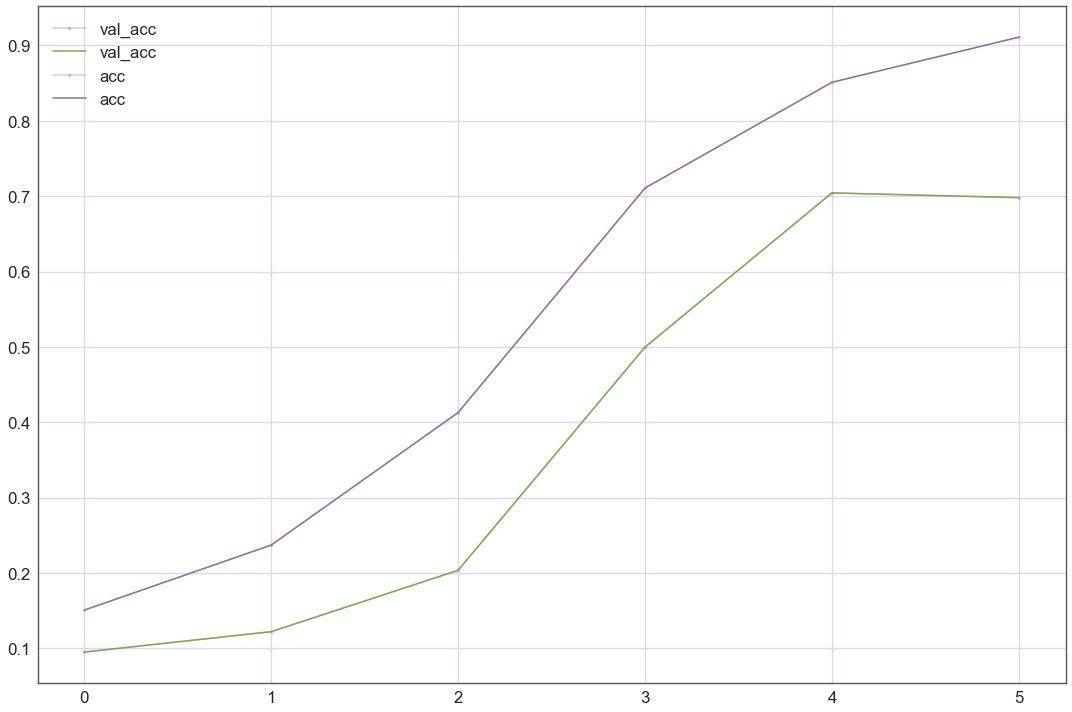

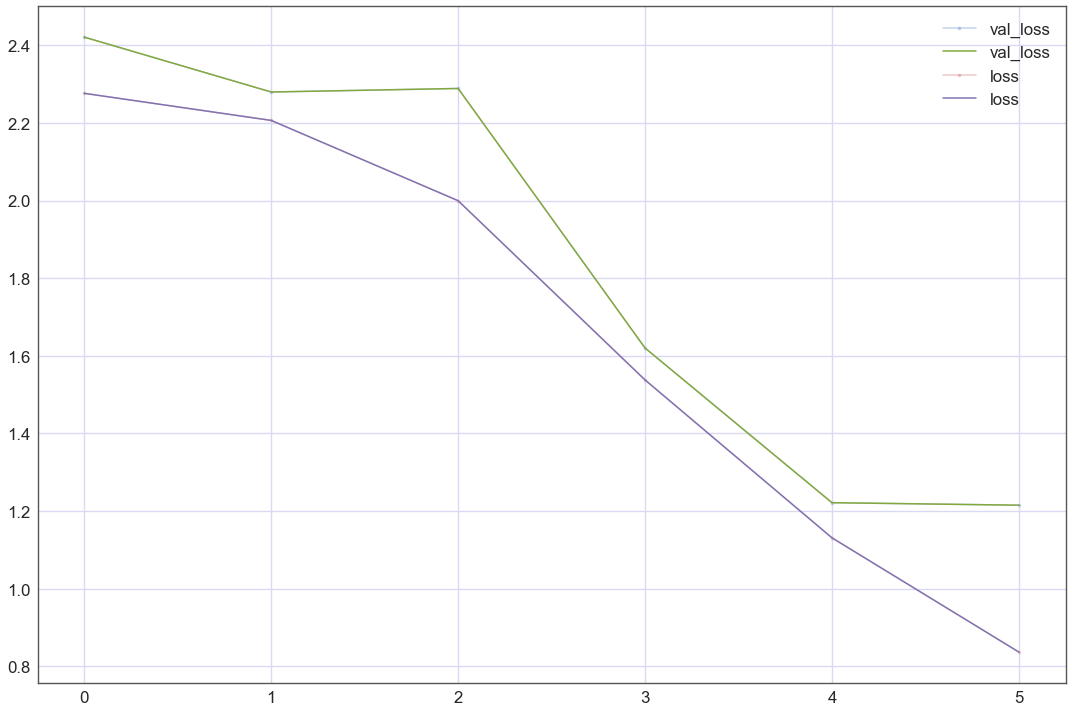

In [27]:
model = get_model(0.3)
fit_model([2, 4], [1e-4, 1e-3], save=True)

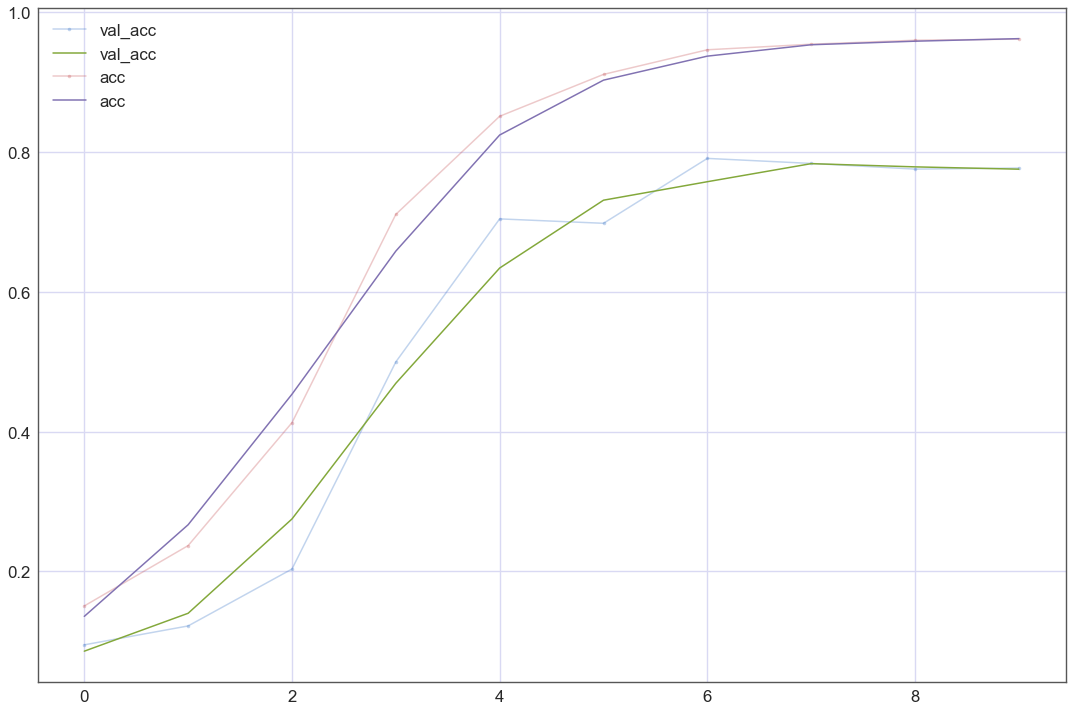

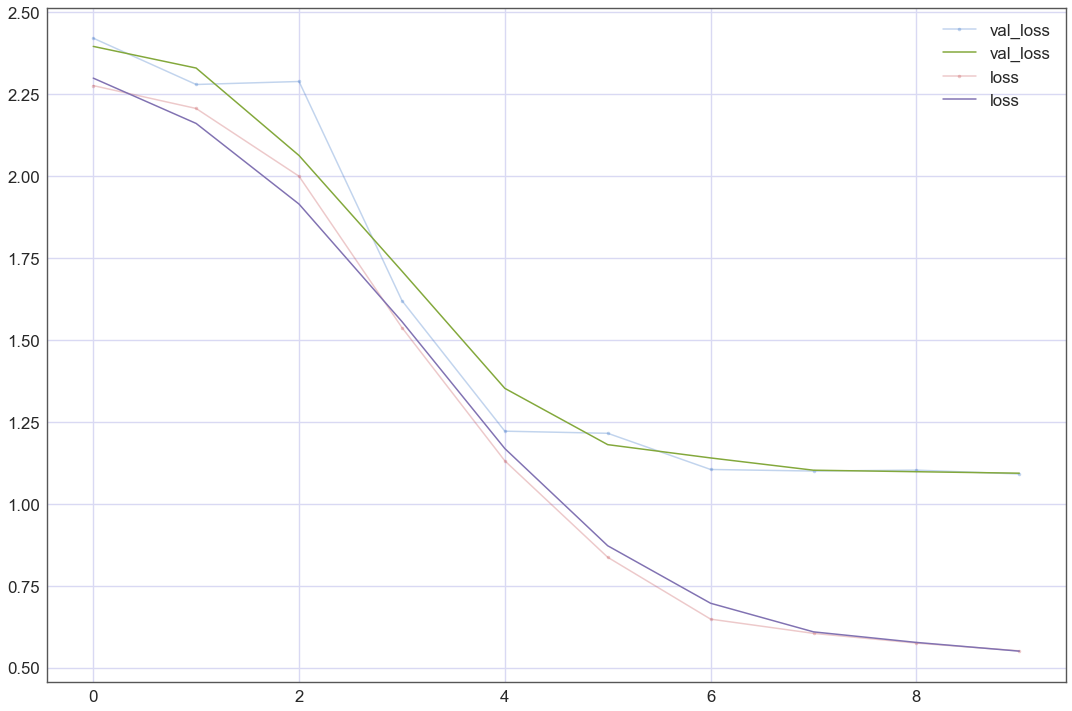

In [29]:
fit_model(2, 1e-4, save=True)

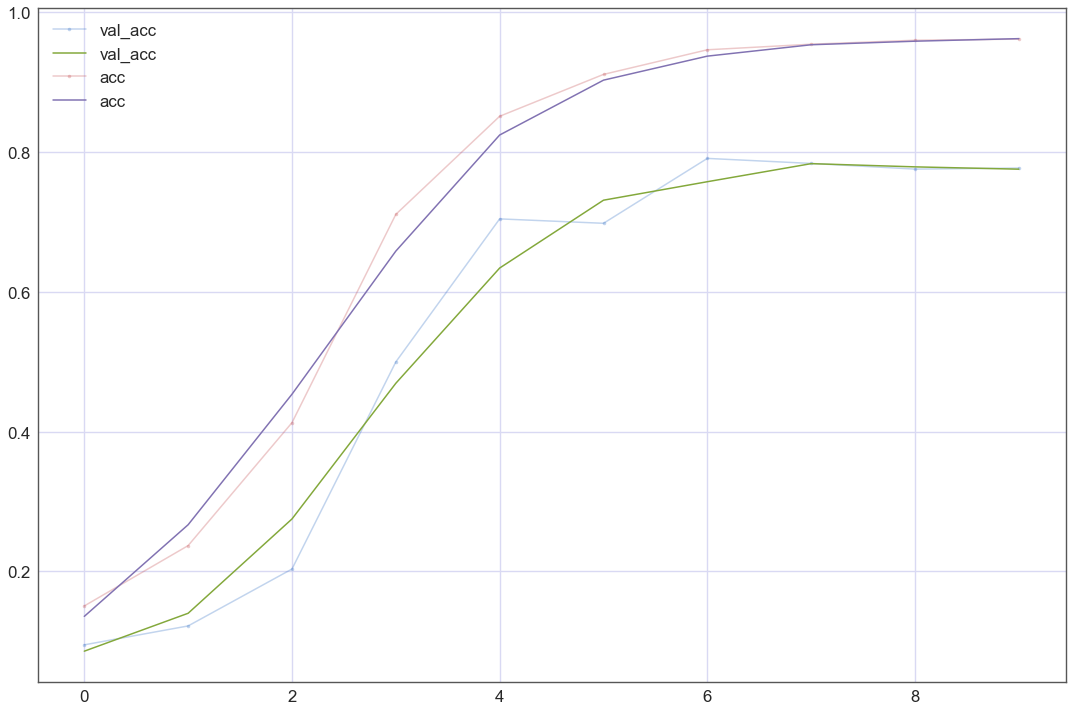

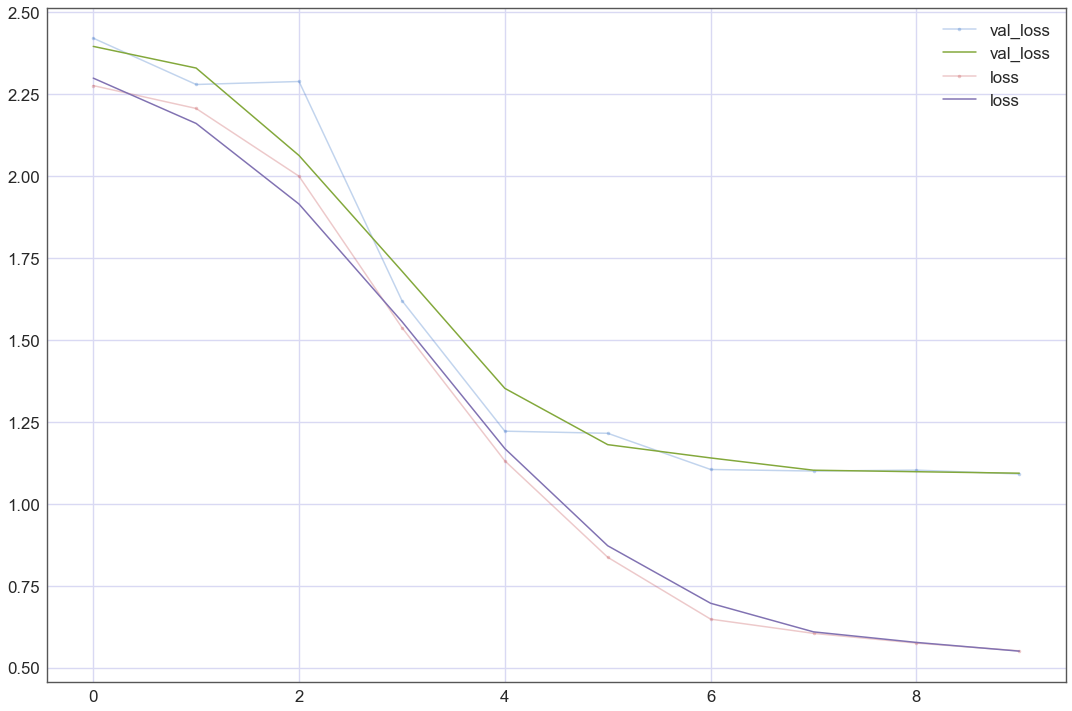

In [31]:
model = inflate_model(model.name)
plot_history()

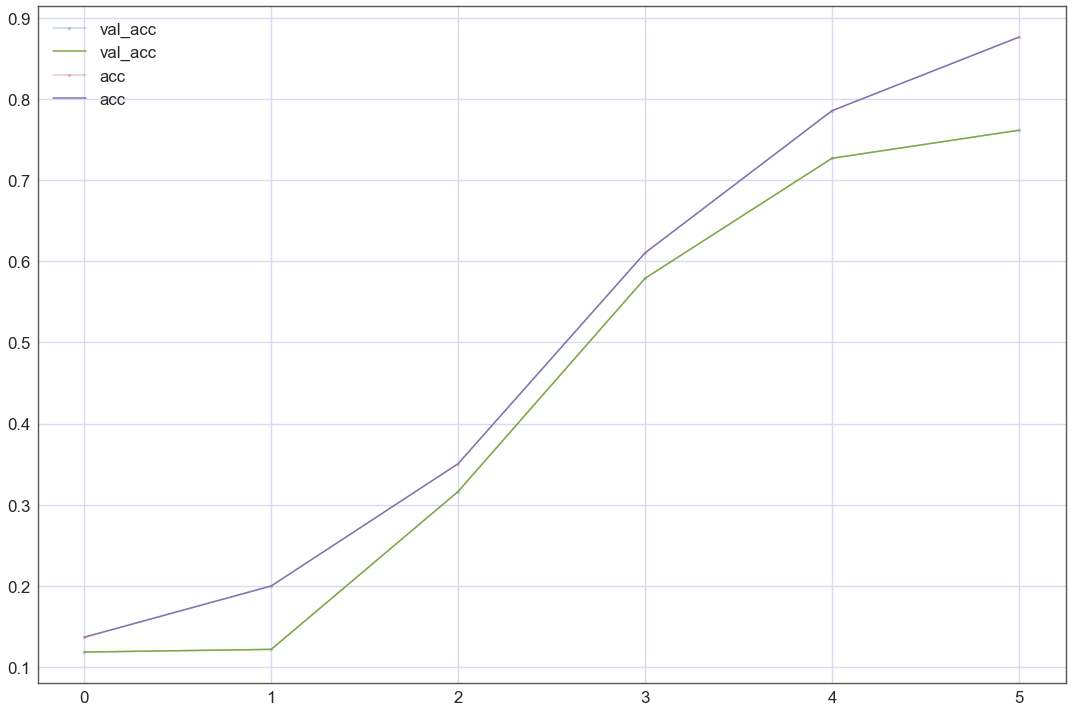

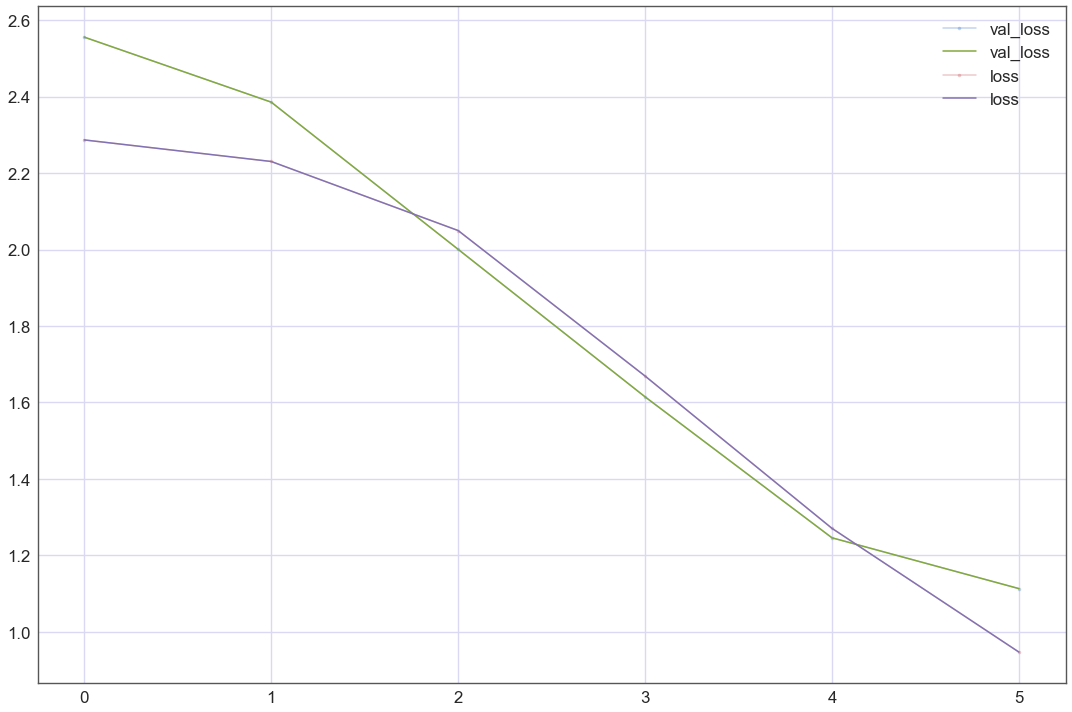

In [30]:
model = get_model(0.5)
fit_model([2, 4], [1e-4, 1e-3], save=True)

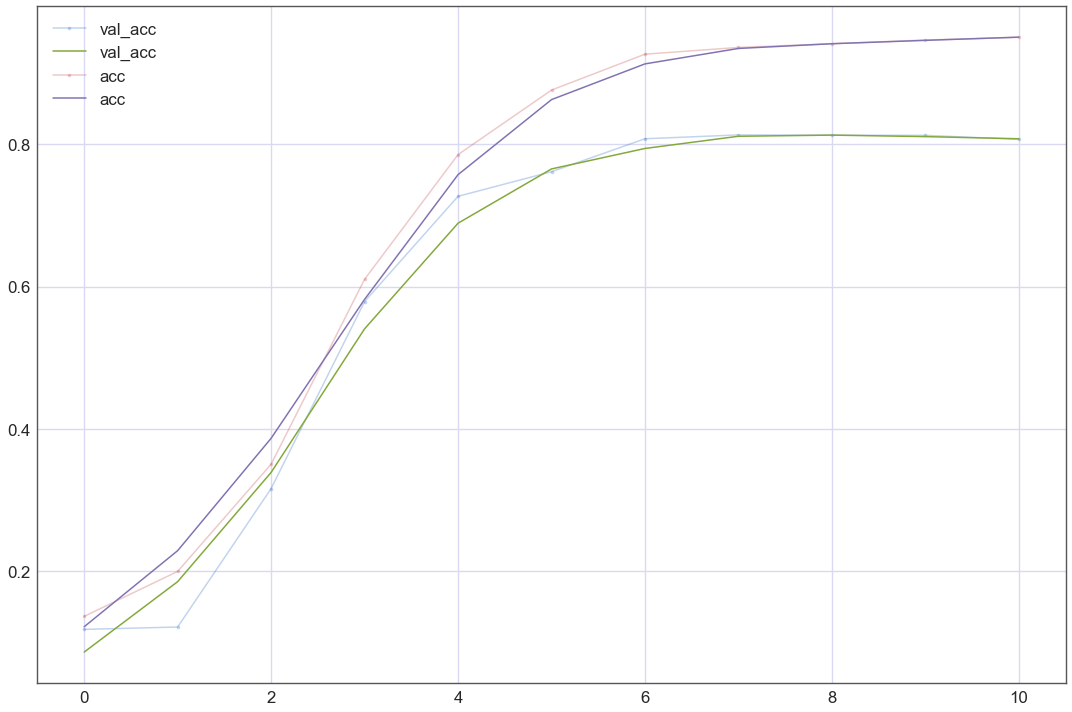

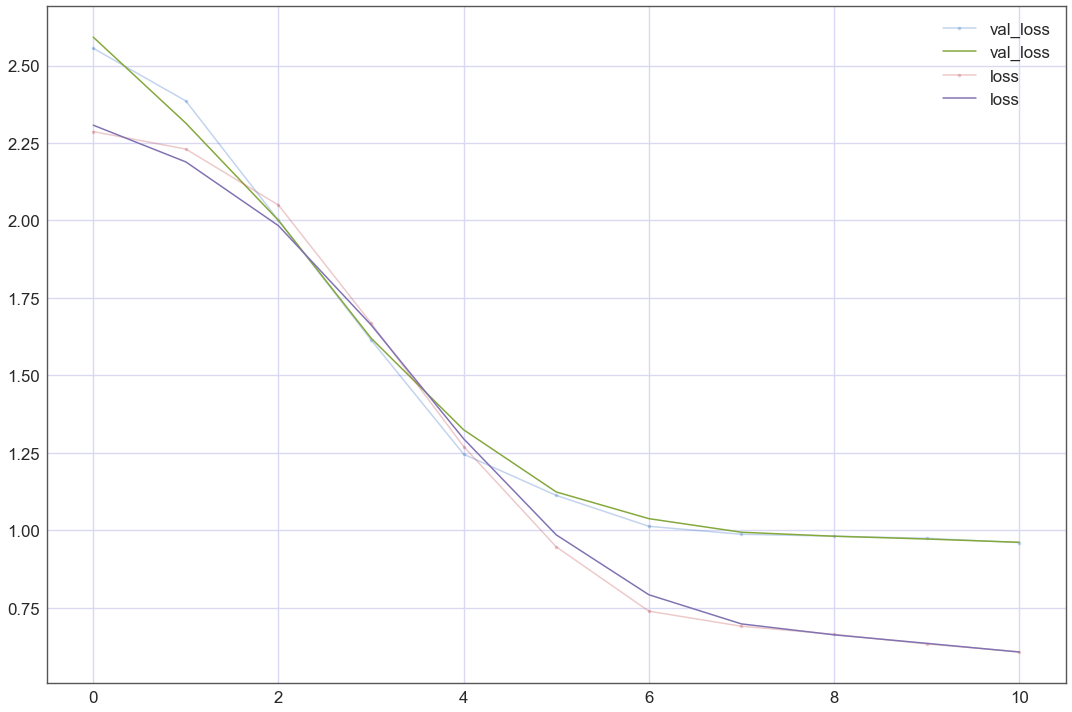

In [31]:
fit_model(5, 1e-4, save=True)

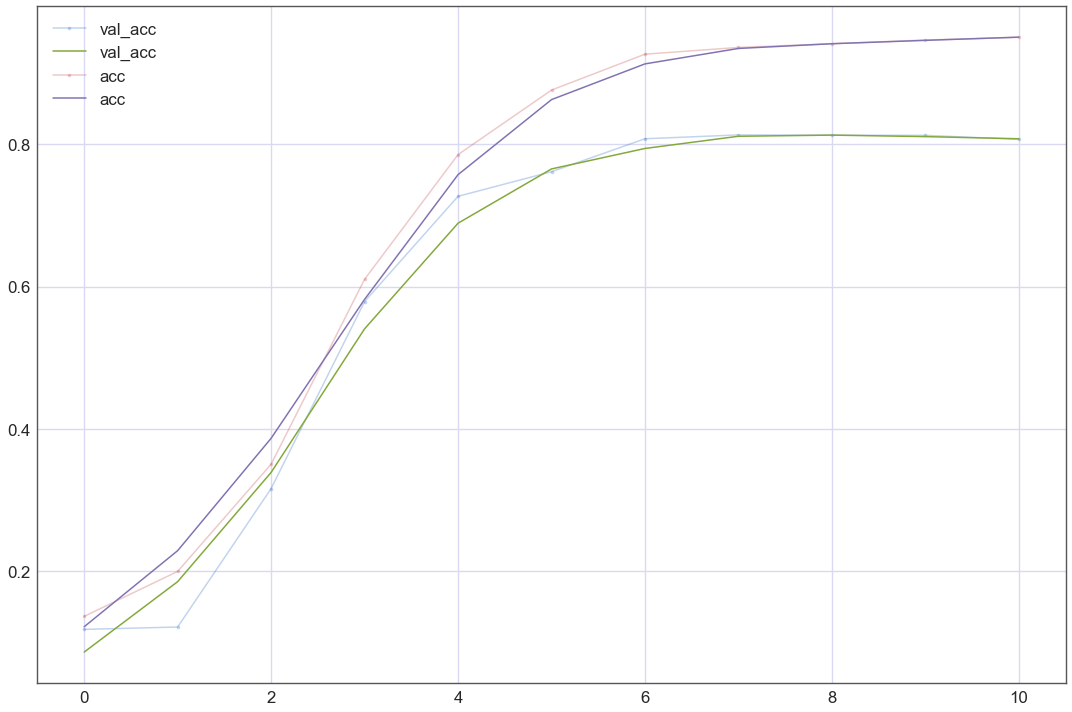

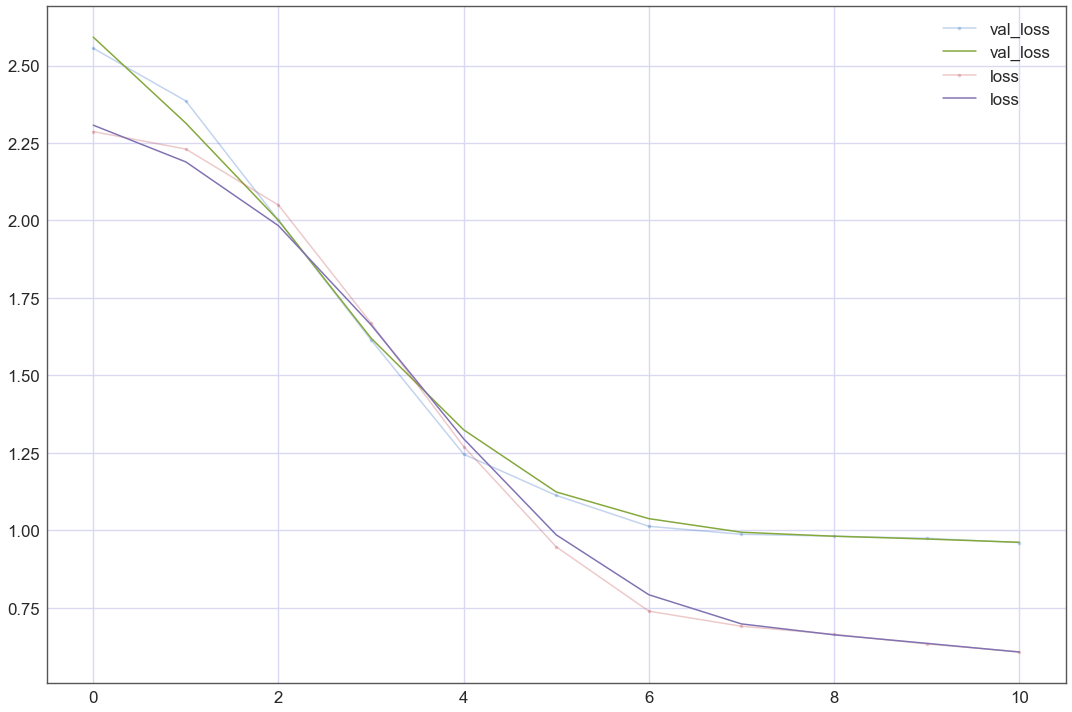

In [32]:
model = inflate_model('FullyConvNet')
plot_history()

# Black and White

In [12]:
def keras_norm(x):
    return K.sqrt(K.sum(K.square(x), -1, keepdims=True))

In [38]:
def get_model(dropout=0, reg=0.01):
    K.clear_session()
    model = Sequential([BatchNormalization(input_shape=(224, 224, 1)),
                        Conv2D(32, (3, 3), strides=(2, 2),
                               padding='same', activation='relu', kernel_regularizer=l2(reg)),
                        BatchNormalization(),
                        Dropout(dropout),
                        Conv2D(64, (3, 3), strides=(2, 2),
                               padding='same', activation='relu', kernel_regularizer=l2(reg)),
                        BatchNormalization(),
                        Dropout(dropout),
                        Conv2D(128, (3, 3), strides=(2, 2),
                               padding='same', activation='relu', kernel_regularizer=l2(reg)),
                        BatchNormalization(),
                        Dropout(dropout),
                        Conv2D(256, (3, 3), strides=(2, 2),
                               padding='same', activation='relu', kernel_regularizer=l2(reg)),
                        BatchNormalization(),
                        Dropout(dropout),
                        Conv2D(10, (3, 3), strides=(2, 2),
                               padding='same', activation='relu', kernel_regularizer=l2(reg)),
                        BatchNormalization(),
                        Dropout(dropout),
                        GlobalAvgPool2D(),
                        Activation('softmax')])
    
    img_in = Input((224, 224, 3))
    x = Lambda(keras_norm, name='norm')(img_in)
    
    model = Model(img_in, model(x))
    model.name = 'FullyConvNetBW'
    model.training_history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
norm (Lambda)                (None, 224, 224, 1)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10)                412854    
Total params: 412,854
Trainable params: 411,872
Non-trainable params: 982
_________________________________________________________________


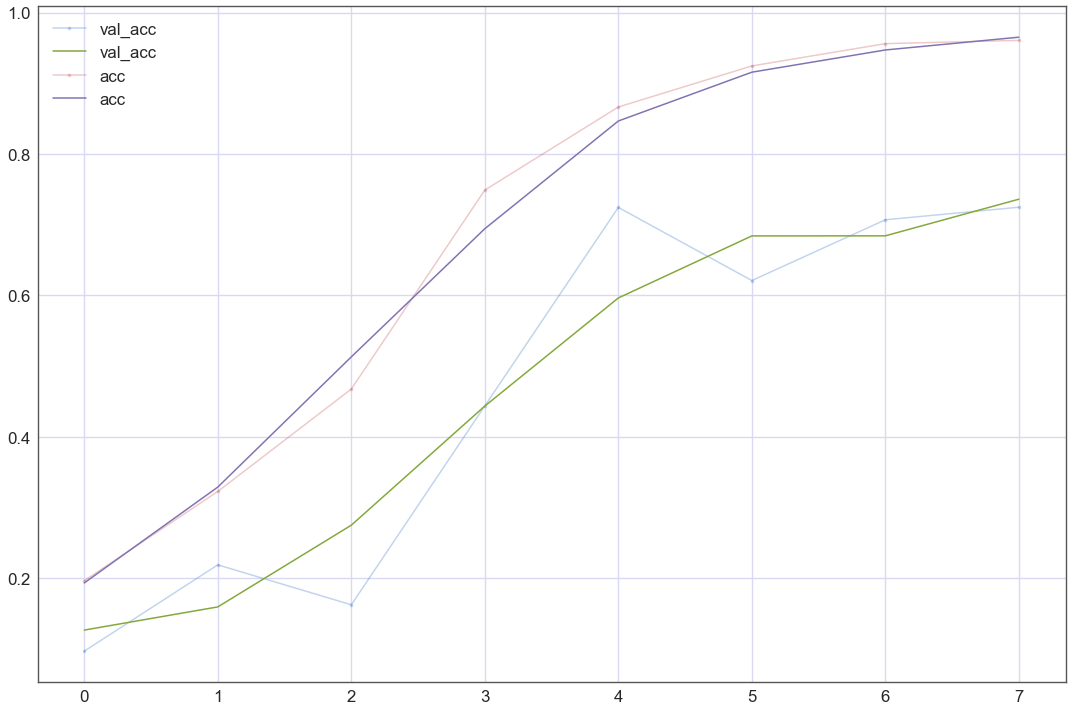

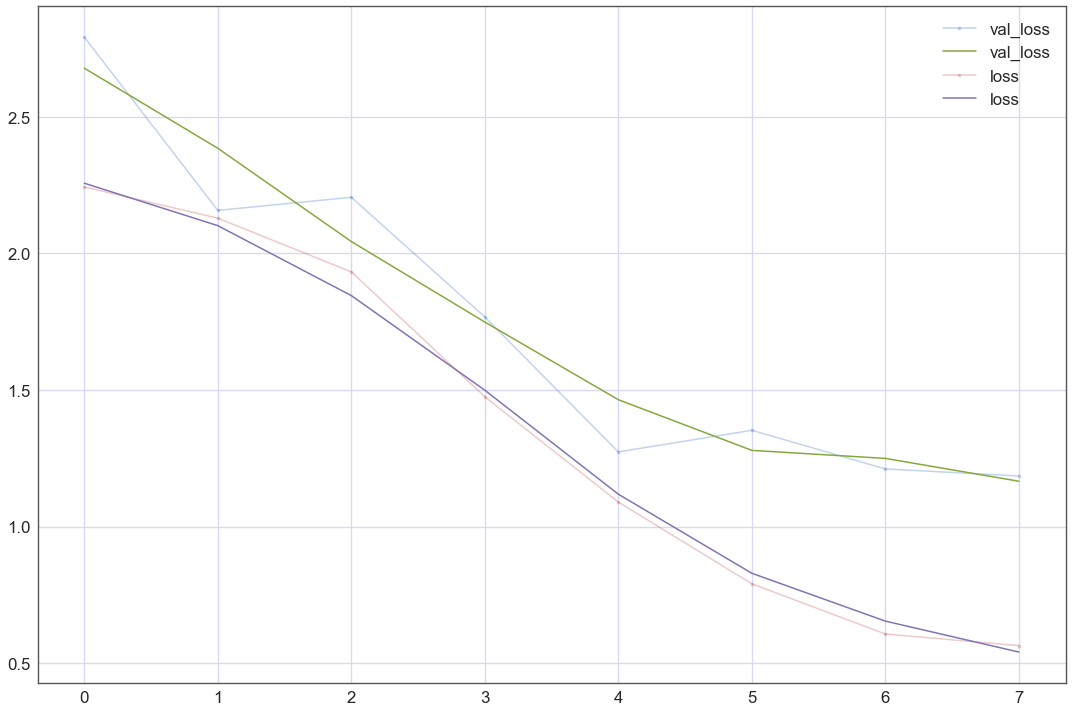

In [31]:
fit_model(2, 1e-4, save=True)